In [29]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import  expon, norm, gamma, beta, lognorm
from scipy.stats._continuous_distns import beta_gen, gamma_gen
from scipy import stats
from datetime import datetime, timedelta

In [35]:
zone1 = pd.read_csv('data/out_1.csv', usecols=["Datum", "Uhrzeit", "Masse [kg]", "Geschwindigkeit [m/s]"])
zone1.columns = ["date", "time", "kg", "m/s"]
zone1 = zone1.dropna(how='all')
zone1['kj'] = 0.5 * zone1['kg'] * (zone1['m/s']**2) /1000
zone1['datetime'] = pd.to_datetime(zone1['date'] + ' ' + zone1['time'])
zone1['timediv h'] = (zone1['datetime'] - zone1['datetime'].shift()).fillna(pd.Timedelta(seconds=0))
zone1['timediv h'] = zone1['timediv h'].apply(lambda x: int(round(x.total_seconds() / 3600)))
zone1.loc[0, 'timediv h'] = zone1['timediv h'].median()


In [36]:
zone2 = pd.read_csv('data/out_2.csv', usecols=["Date", "Uhrzeit", "m [kg]", "v [m/s]"])
zone2.columns = ["date", "time", "kg", "m/s"]
zone2 = zone2.dropna(how='all')
zone2.loc[zone2['kg'] == 0.0, 'kg'] = zone2['kg'].median()
zone2['kj'] = 0.5 * zone2['kg'] * (zone2['m/s']**2) /1000
zone2['datetime'] = pd.to_datetime(zone2['date'] + ' ' + zone2['time'])
zone2['timediv h'] = (zone2['datetime'] - zone2['datetime'].shift()).fillna(pd.Timedelta(seconds=0))
zone2['timediv h'] = zone2['timediv h'].apply(lambda x: int(round(x.total_seconds() / 3600)))
zone2.loc[0, 'timediv h'] = zone2['timediv h'].median()

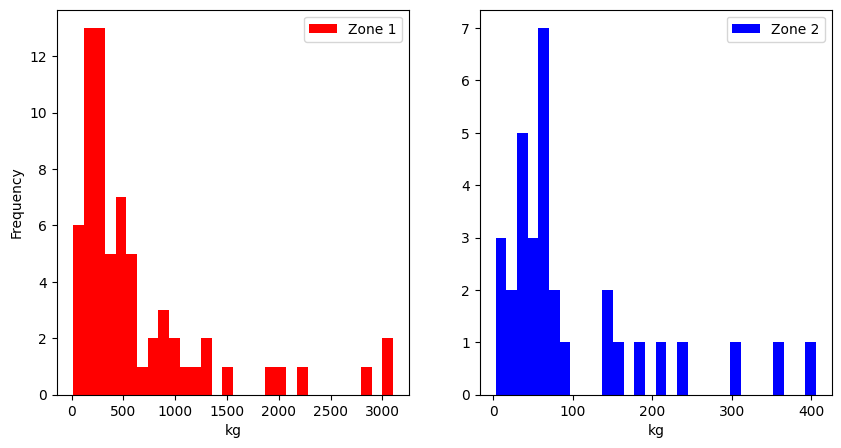

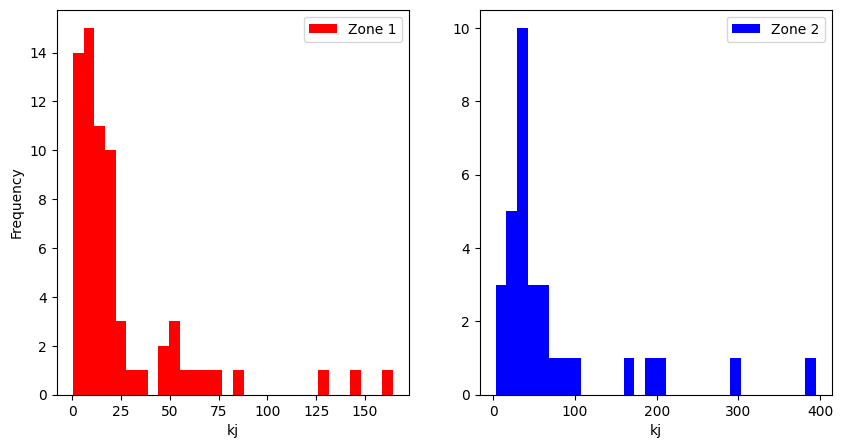

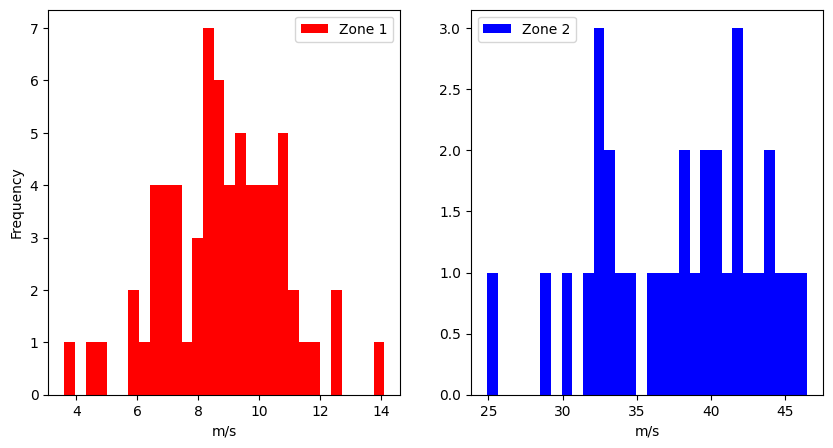

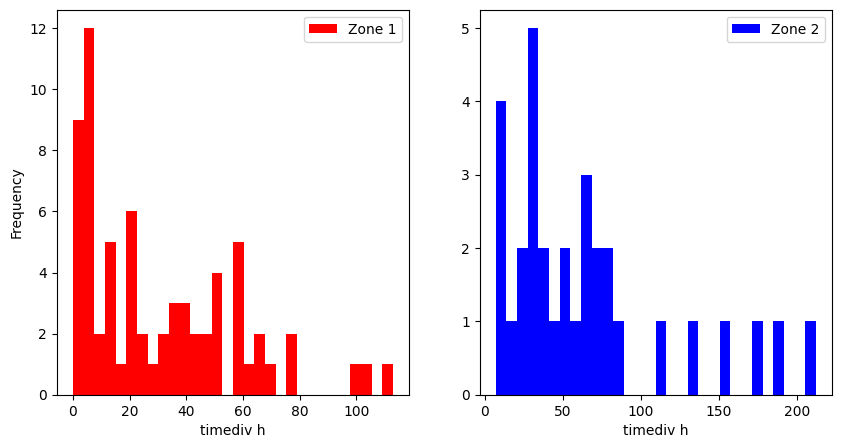

In [37]:
num_bins = 30  # Change this value to adjust the number of bins

# Plot the histograms for 'kg'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.hist(zone1['kg'], bins=num_bins, color='red', label='Zone 1')
ax2.hist(zone2['kg'], bins=num_bins, color='blue', label='Zone 2')

ax1.set_xlabel('kg')
ax1.set_ylabel('Frequency')
ax1.legend()
ax2.set_xlabel('kg')
ax2.legend()
plt.show()

# Plot the histograms for 'kj'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.hist(zone1['kj'], bins=num_bins, color='red', label='Zone 1')
ax2.hist(zone2['kj'], bins=num_bins, color='blue', label='Zone 2')

ax1.set_xlabel('kj')
ax1.set_ylabel('Frequency')
ax1.legend()
ax2.set_xlabel('kj')
ax2.legend()
plt.show()

# Plot the histograms for 'm/s'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.hist(zone1['m/s'], bins=num_bins, color='red', label='Zone 1')
ax2.hist(zone2['m/s'], bins=num_bins, color='blue', label='Zone 2')

ax1.set_xlabel('m/s')
ax1.set_ylabel('Frequency')
ax1.legend()
ax2.set_xlabel('m/s')
ax2.legend()
plt.show()

# Plot the histograms for 'timediv h'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.hist(zone1['timediv h'], bins=num_bins, color='red', label='Zone 1')
ax2.hist(zone2['timediv h'], bins=num_bins, color='blue', label='Zone 2')

ax1.set_xlabel('timediv h')
ax1.set_ylabel('Frequency')
ax1.legend()
ax2.set_xlabel('timediv h')
ax2.legend()
plt.show()


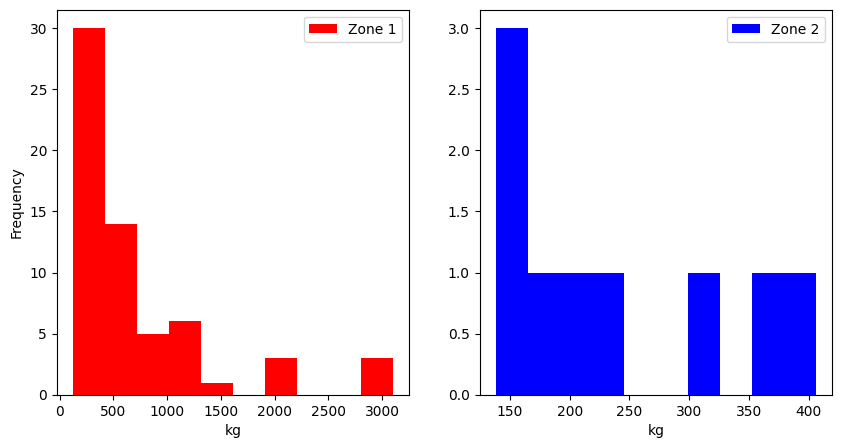

In [41]:
# Plot the histograms for 'kg' with values over 100kg
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.hist(zone1[zone1['kg'] > 100]['kg'], bins=10, color='red', label='Zone 1')
ax2.hist(zone2[zone2['kg'] > 100]['kg'], bins=10, color='blue', label='Zone 2')

ax1.set_xlabel('kg')
ax1.set_ylabel('Frequency')
ax1.legend()
ax2.set_xlabel('kg')
ax2.legend()
plt.show()

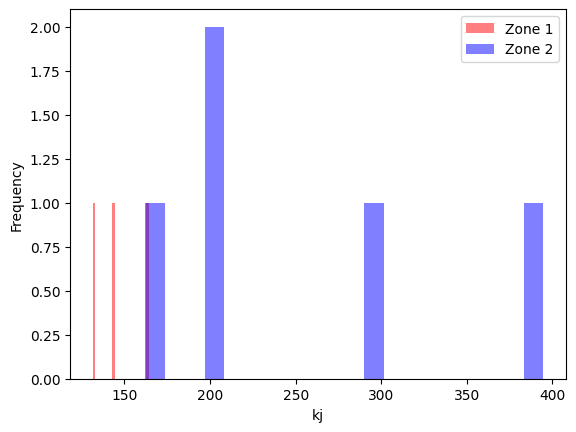

In [45]:
# Only keep entries bigger than 100
zone1_kj = zone1[zone1['kj'] > 100]
zone2_kj = zone2[zone2['kj'] > 100]

# Plot the histograms for 'kj'
fig, ax = plt.subplots()
ax.hist(zone1_kj['kj'], bins=20, alpha=0.5, color='red', label='Zone 1')
ax.hist(zone2_kj['kj'], bins=20, alpha=0.5, color='blue', label='Zone 2')

ax.set_xlabel('kj')
ax.set_ylabel('Frequency')
ax.legend()
plt.show()
